In [1]:
from bvp import our_own_bvp_solve
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
# The following is the system for the midterm.
gamma = 5 / 3
v_plus = 3 / 5
v_star = gamma / (gamma + 2)
e_minus = (gamma + 2) * (v_plus - v_star) / 2 / gamma / (gamma + 1)

# ODE
f = lambda x, y: np.array([y[0] * (y[0] - 1) + gamma * (y[1] - y[0] * e_minus),
                           y[0] * (-(y[0] - 1) ** 2 / 2 + y[1] - e_minus + gamma * e_minus * (y[0] - 1))])

a = 0
b = 20
n = 40
dim = 2

# We try to start at the source and move to the sink
bc = lambda ya, yb: np.array([
    *(ya[0] - np.array([1, 3 / 50])),  # start at source
    *yb[0],                            # finish at the sink
    yb[1][0] + yb[1][1] * 0.33         # specify slope at sink
])

In [8]:
y0 = np.zeros((n + 1, dim))
solution = our_own_bvp_solve(f, a, b, n, y0, dim, bc)

/home/kylrth/programming/python/acme436/boundaryvalue/bvp.py:45: RankWarning: The fit may be poorly conditioned
  cf0 = np.polynomial.chebyshev.chebfit(np.linspace(a, b, len(y0)), y0, n)


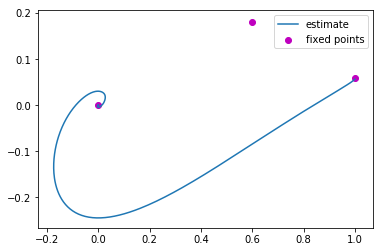

In [9]:
# plotting
dom = np.linspace(a, b, 1000)
plt.plot(solution[0](dom), solution[1](dom), label='estimate')
plt.scatter([1, 0, 3 / 5], [3 / 50, 0, 9 / 50], color='m', label='fixed points')
plt.legend()
plt.show()